## VABAM: Variational Autoencoder for Frequency-based Biosignal Augmentation within Morphological Identities.

In [1]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import copy
import pickle
import re


from Models.Caller import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects
from BatchEvaluation import LoadModelConfigs, LoadParams
from Utilities.EvaluationMain import *
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC

import seaborn as sns
import pandas as pd

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))         

#### MAPE Calculator

In [2]:
def Denorm (NormX, MaxX, MinX):
    return NormX * (MaxX - MinX) + MinX 

def MAPECal (TrueData, PredSigRec, MaxX, MinX):
    # Denormalization
    DenormTrueData = Denorm(TrueData, MaxX, MinX).copy()
    DenormPredSigRec = Denorm(PredSigRec, MaxX, MinX).copy()
   
    # MAPE
    #MSEnorm = np.mean((TrueData - PredSigRec)**2)
    MAPEdenorm = np.mean(np.abs((DenormTrueData - DenormPredSigRec) / DenormTrueData)) * 100
    MAPEnorm = np.mean(np.abs(((TrueData+1e-7) - PredSigRec) / (TrueData+1e-7))) * 100

    return MAPEnorm, MAPEdenorm


def MSECal (TrueData, PredSigRec, MaxX, MinX):
    # Denormalization
    DenormTrueData = Denorm(TrueData, MaxX, MinX).copy()
    DenormPredSigRec = Denorm(PredSigRec, MaxX, MinX).copy()
   
    # MAPE
    MSEdenorm = np.mean((DenormTrueData - DenormPredSigRec)**2)
    MSEnorm = np.mean((TrueData - PredSigRec)**2)
    
    return MSEnorm, MSEdenorm

### Score aggregation process

In [3]:
def Aggregation (ConfigName, ConfigPath, NJ=1, MetricCut = 1., BatSize=3000):

    print()
    print(ConfigName)
    
    # Configuration and Object part
    print('-----------------------------------------------------' )
    print('Loading configurations and objects' )
    ## Loading the model configurations
    EvalConfigs = ReadYaml(ConfigPath)
    ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)
    
    ## Loading parameters for the evaluation
    Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
    Params['Common_Info'] = EvalConfigs['Common_Info']
    
    ## Object Load path
    ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'_Nj'+str(NJ)+'.pkl'
    SampZjLoadPath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'



    # Data part
    print('-----------------------------------------------------' )
    print('Loading data')
    ## Loading data
    AnalData = np.load('./Data/ProcessedData/Val'+str(Params['SigType'])+'.npy')
    
    ## Intermediate parameters 
    SigDim = AnalData.shape[1]
    DataSize = AnalData.shape[0]
    
    with open('./Data/ProcessedData/SigMax.pkl', 'rb') as f:
        SigMax = pickle.load(f)
    with open('./Data/ProcessedData/SigMin.pkl', 'rb') as f:
        SigMin = pickle.load(f)
    
    
    if 'ART' in ConfigName:
        MaxX, MinX = SigMax['ART'], SigMin['ART']
    elif 'PLETH' in ConfigName:
        MaxX, MinX = SigMax['PLETH'], SigMin['PLETH']
    elif 'II' in ConfigName:
        MaxX, MinX = SigMax['II'], SigMin['II']


    
    # Model part
    print('-----------------------------------------------------' )
    print('Loading model structures')
    ## Calling Modesl
    SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName, ModelSummary=False)
    
    ## Setting Model Specifications and Sub-models
    if Params['LossType'] =='Default':
        EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
    elif Params['LossType'] =='FACLosses':
        EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts
            
    ## The generation model for evaluation
    RecOut = ReconModel(FeatGenModel.output)
    GenModel = Model(FeatGenModel.input, RecOut)

    ## The sampling model for evaluation
    Zs_Out = SigRepModel.get_layer('Zs').output
    SampModel = Model(EncModel.input, Zs_Out)


    # Evaluating MAPEs
    ## Prediction
    print('-----------------------------------------------------' )
    print('MAPE calculation')
    PredSigRec = SigRepModel.predict(AnalData, batch_size=BatSize, verbose=1)[-2]
   
    ## MAPE    
    MAPEnorm, MAPEdenorm = MAPECal(AnalData, PredSigRec, MaxX, MinX)
    ## MSE    
    MSEnorm, MSEdenorm = MSECal(AnalData, PredSigRec, MaxX, MinX)

    # Evaluating Mutual information
    ## Creating new instances
    NewEval = Evaluator()
    # Populating it with the saved data
    DeserializeObjects(NewEval, ObjLoadPath)

    # Post evaluation of KLD
    ## MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
    PostSamp = NewEval.SelPostSamp( MetricCut)

    ## Calculation of KLD
    NewEval.GenModel = GenModel
    NewEval.KLD_TrueGen(AnalSig=AnalData, PlotDist=False) 
    MeanKld_GTTG = (NewEval.KldPSD_GenTrue + NewEval.KldPSD_TrueGen) / 2

    print(MeanKld_GTTG)

    ''' Renaming columns '''
    # r'I(V;Z)'
    # r'I(V; \acute{Z} \mid Z)'
    # r'I(V;\acute{Z})'
    # r'I(V;\acute{\Theta} \mid \acute{Z})'
    # r'I(S;\acute{Z})'
    # r'I(S;\acute{\Theta} \mid \acute{Z})'
    
    MIVals = pd.DataFrame(NewEval.SubResDic)
    MIVals.columns = [r'(1) I(V;Z)',r'(2) $I(V; \acute{Z} \mid Z)$',  r'(3) $I(V;\acute{Z})$', r'(4) $I(V;\acute{\Theta} \mid \acute{Z})$', r'(5) $I(S;\acute{Z})$', r'(6) $I(S;\acute{\Theta} \mid \acute{Z})$']
    MIVals['Model'] = ConfigName
    longMI = MIVals.melt(id_vars='Model', var_name='Metrics', value_name='Values')

    return MSEnorm, MSEdenorm, MAPEnorm, MAPEdenorm, longMI, MeanKld_GTTG
    

In [4]:
Exp = r'ART|II|\d+'  # Regular expression pattern for 'ART', 'II', or any sequence of digits.
YamlPath = './Config/' # Directory path where the YAML configuration files are stored.

EvalConfigList = os.listdir(YamlPath) # Retrieve a list of all files in the YamlPath directory.
EvalConfigList = [i for i in EvalConfigList if 'Eval' in i] # Filter the list to include only files that contain 'Eval' in their names.

# Iterate through each filtered configuration file.
for EvalConfig in EvalConfigList:
    print(EvalConfig)  
    
    # Read the configuration file's contents.
    ModelConfigs = ReadYaml(YamlPath + EvalConfig) 
    # Filter the configurations to include only those with 'ART' or 'II'.
    ConfigNames = [i for i in ModelConfigs if 'ART' in i or 'II' in i]

    # Initialize lists to store results.
    ModelName = []
    MSEnormRes = []
    MSEdenormRes = []
    MAPEnormRes = []
    MAPEdenormRes = []
    MeanKldRes = []
    MItables = pd.DataFrame()  # Initialize an empty DataFrame for MI tables.
    
    # Iterate through each filtered configuration name.
    for ConfigName in ConfigNames:
        # Perform aggregation (custom function) and retrieve results.
        MSEnorm, MSEdenorm, MAPEnorm, MAPEdenorm, longMI, MeanKld_GTTG = Aggregation(ConfigName, YamlPath + EvalConfig, NJ=1)
        
        # Append the results to their respective lists.
        ModelName.append(ConfigName)
        MSEnormRes.append(MSEnorm)
        MSEdenormRes.append(MSEdenorm) 
        MAPEnormRes.append(MAPEnorm)
        MAPEdenormRes.append(MAPEdenorm) # it's reported for reference, it is not used as an official metric in this paper. 
        MeanKldRes.append(MeanKld_GTTG)
        
        # Concatenate the current longMI DataFrame to the MItables DataFrame.
        MItables = pd.concat([MItables, longMI]).copy()
    
    # Extract relevant parts from EvalConfig to name the table.
    TableName = re.findall(Exp, EvalConfig)
    TableName = ''.join(TableName)  # Concatenate the extracted parts.
    
    # Save the MItables to a CSV file.
    MItables.to_csv('./EvalResults/Tables/MI_' + str(TableName) + '.csv', index=False)

    # Save the AccKLDtables to a CSV file.
    DicRes = {'Model': ModelName , 'MeanKldRes': MeanKldRes, 'MSEnorm':MSEnormRes , 'MSEdenorm': MSEdenormRes, 'MAPEnorm': MAPEnormRes, 'MAPEdenorm': MAPEdenormRes }
    AccKLDtables = pd.DataFrame(DicRes)
    AccKLDtables.to_csv('./EvalResults/Tables/AccKLD_' + str(TableName) + '.csv', index=False)

EvalConfigART500.yml

FACFC_ART_30_500
-----------------------------------------------------
Loading configurations and objects
-----------------------------------------------------
Loading data
-----------------------------------------------------
Loading model structures
OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ added
kl_Loss_TC added
kl_Loss_DTC added
kl_Loss_FC added
Model weights loaded
-----------------------------------------------------
MAPE calculation
20/20 [==============================] - 71s 3s/step
The total number of sets in NestedZs: 17625
2/2 [==============================] - 11s 971ms/step
KldPSD_GenTrue:  0.09395741199879287
KldPSD_TrueGen:  0.09151182322179668
MeanKld_GTTG:  0.09273461761029478
0.09273461761029478

FACFC_ART_50_500
-----------------------------------------------------
Loading configurations and objects
-----------------------------------------------------
Loading data
-----------------------------------------------------
Loading model struct

In [2]:
TableName = 'MI_ART500'
MItables = pd.read_csv('./EvalResults/Tables/'+TableName+'.csv')


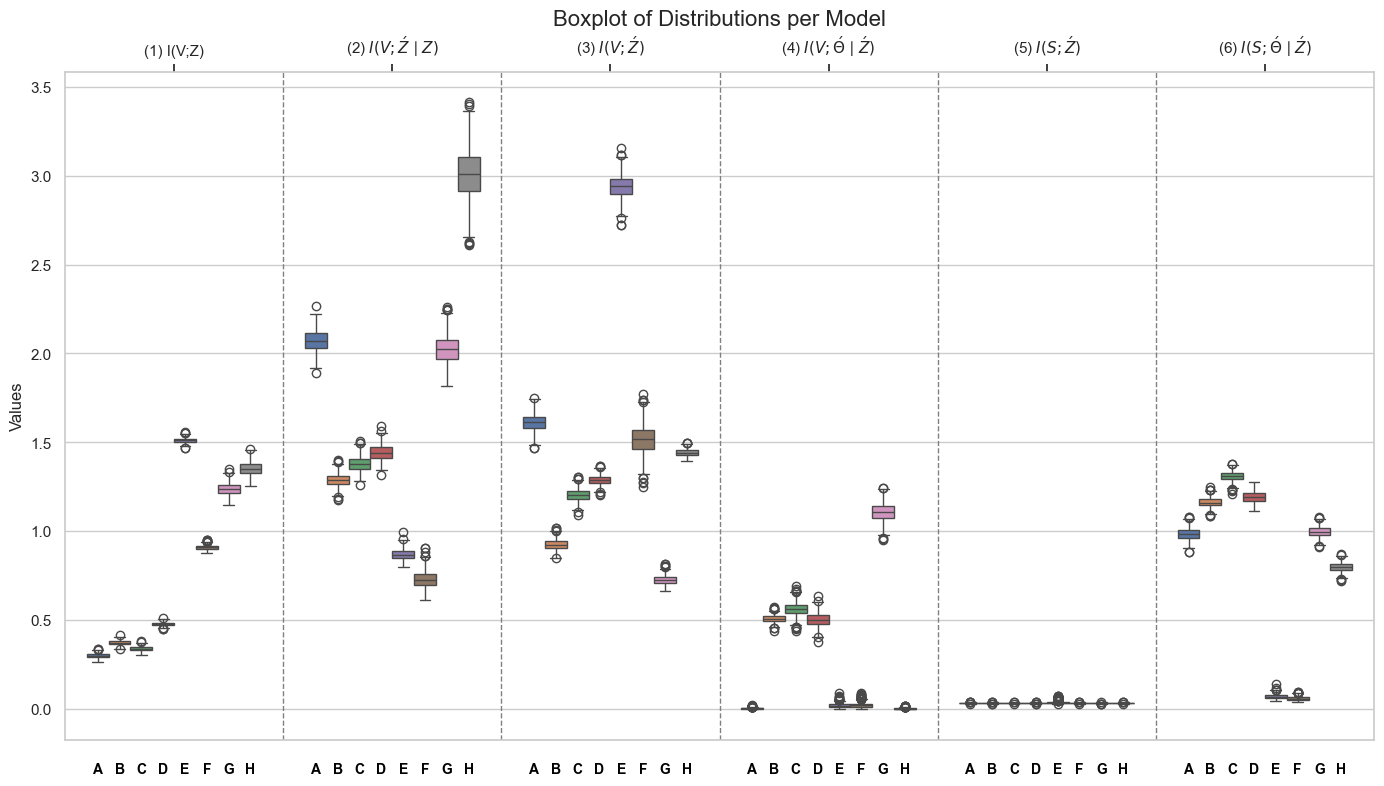

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a larger figure to accommodate the box plot
plt.figure(figsize=(14, 8))

# Create a box plot
ax = sns.boxplot(x='Metrics', y='Values', hue='Model', data=MItables)

# Add title and rotate x-tick labels for better readability
plt.title('Boxplot of Distributions per Model', fontsize=16)

# Move x-axis to the top of the figure
ax.xaxis.tick_top()
# Set x-axis label to the top
ax.xaxis.set_label_position('top') 
plt.xlabel(None)

# Calculate the positions where you want to draw the lines
categories = MItables['Metrics'].nunique()
models = MItables['Model'].nunique()

# Draw vertical lines to separate different Metrics
for i in range(1, categories):
    plt.axvline(x=i-0.5, color='grey', linestyle='--', linewidth=1)

# Define alphabet labels for each model
alphabet = list('ABCDEFGH')
model_labels = dict(zip(MItables['Model'].unique(), alphabet))

# Annotate each box with the corresponding model letter
for tick, label in zip(range(len(ax.get_xticklabels())), ax.get_xticklabels()):
    metrics_label = label.get_text()
    model_positions = MItables[MItables['Metrics'] == metrics_label]['Model'].unique()
    
    for pos, model in enumerate(model_positions):
        # Calculate position for annotation
        x_offset = (pos - models / 2) / (models + 2)
        # Annotate with the corresponding letter
        plt.text(tick + x_offset+0.05, -0.05, model_labels[model], 
                 horizontalalignment='center', size='small', color='black',weight='semibold',
                 transform=ax.get_xaxis_transform())

# Remove the legend
ax.legend_.remove()  # or ax.get_legend().remove()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()



'$A_{1}$'

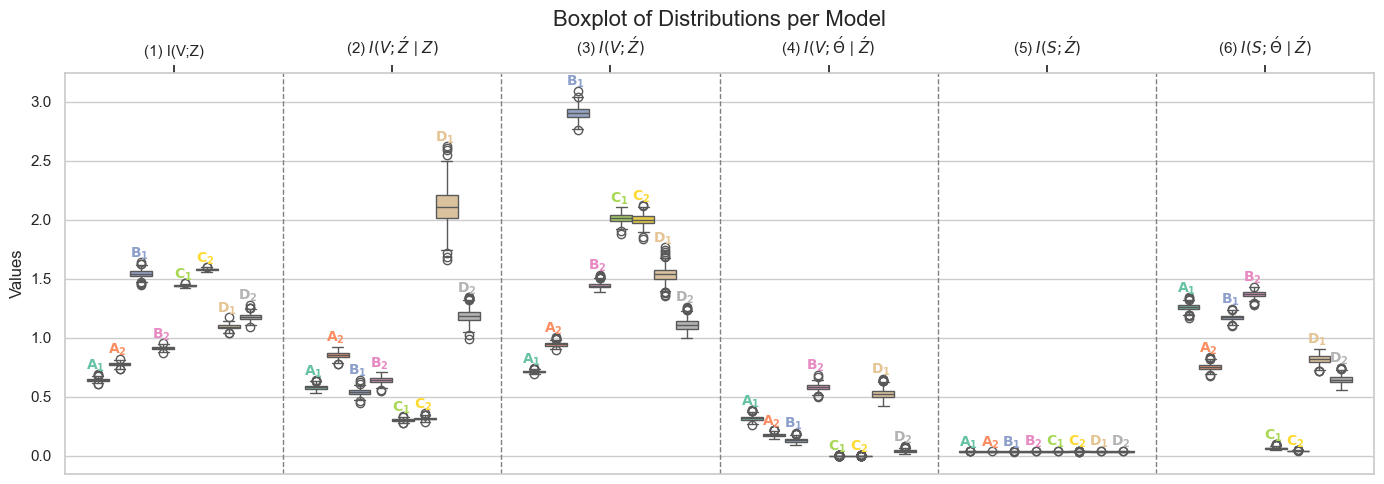

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a larger figure to accommodate the box plot
plt.figure(figsize=(14, 5))

# Define a color palette
models = MItables['Model'].unique()
palette = sns.color_palette("Set2", len(models))

# Create a box plot with the specified palette
ax = sns.boxplot(x='Metrics', y='Values', hue='Model', data=MItables, palette=palette)

# Add title and move x-axis to the top of the figure
plt.title('Boxplot of Distributions per Model', fontsize=16)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.xlabel(None)

# Draw vertical lines to separate different Metrics
categories = MItables['Metrics'].nunique()
for i in range(1, categories):
    plt.axvline(x=i-0.5, color='grey', linestyle='--', linewidth=1)

# Define alphabet labels for each model
alphabet = [r'$\mathbf{A_{1}}$', r'$\mathbf{A_{2}}$', r'$\mathbf{B_{1}}$', r'$\mathbf{B_{2}}$', 
            r'$\mathbf{C_{1}}$', r'$\mathbf{C_{2}}$', r'$\mathbf{D_{1}}$', r'$\mathbf{D_{2}}$']

model_labels = dict(zip(models, alphabet))

# Annotate each box with the corresponding model letter
for tick, label in zip(range(len(ax.get_xticklabels())), ax.get_xticklabels()):
    metrics_label = label.get_text()
    model_positions = MItables[MItables['Metrics'] == metrics_label]['Model'].unique()
    
    for pos, model in enumerate(model_positions):
        # Get the color for the current model
        color = palette[list(models).index(model)]
        # Calculate position for annotation
        x_offset = (pos - len(models) / 2) / (len(models) + 2)
        x = tick + x_offset + 0.05
        subset = MItables[(MItables['Metrics'] == metrics_label) & (MItables['Model'] == model)]
        y_violin = subset['Values'].max() + 0.04  # Or any other representative value

        # Annotate with the corresponding letter
        plt.text(x-0.01, y_violin, model_labels[model], 
                 horizontalalignment='center', size='small', color=color, weight='bold')

# Remove the legend
ax.legend_.remove()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()


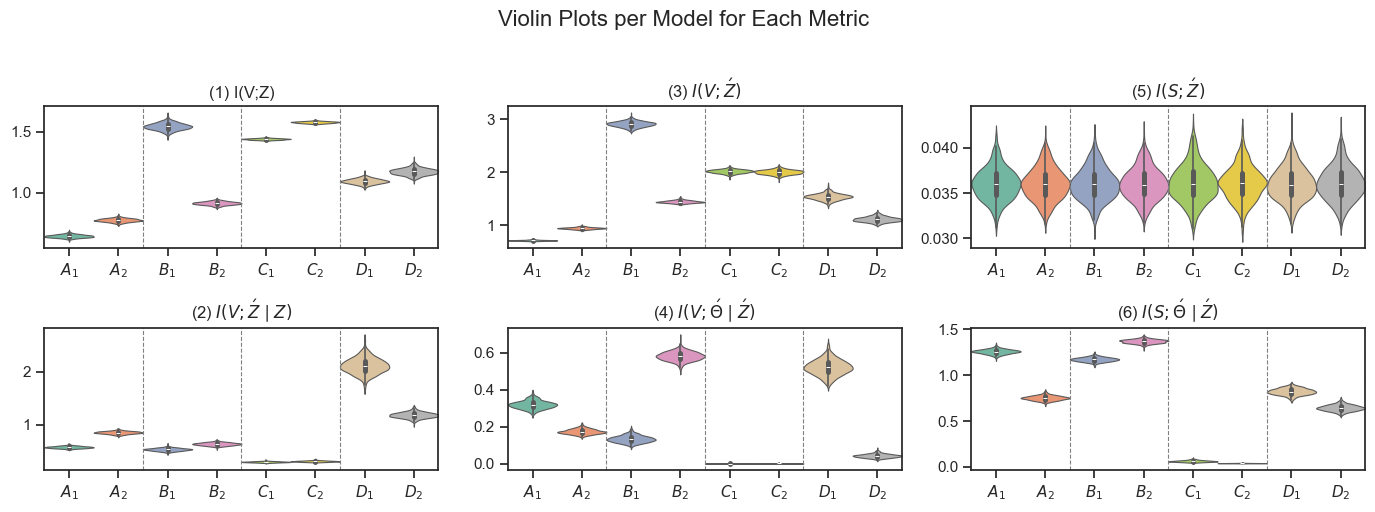

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# 플롯의 스타일을 'ticks'로 설정하여 배경을 플레인하게 만듭니다.
sns.set(style="ticks")

# 'Metrics'의 고유한 값들을 가져옵니다.
metrics_categories = MItables['Metrics'].unique()
ModelLabels = [r'$A_{1}$', r'$A_{2}$', r'$B_{1}$', r'$B_{2}$', r'$C_{1}$', r'$C_{2}$', r'$D_{1}$', r'$D_{2}$']


# 전체 데이터셋에서 'Values'의 최소 및 최대 값을 찾습니다.
global_min = MItables['Values'].min()
global_max = MItables['Values'].max()

# 3x2 subplot 구조를 생성합니다.
fig, axes = plt.subplots(2, 3, figsize=(14, 5))  # 전체 그림의 크기를 조정합니다.
axes = axes.flatten(order='F')  # 2D axes 배열을 1D 배열로 변환합니다.

# 각 'Metrics'에 대해 바이올린 플롯을 생성합니다.
for ax, metric in zip(axes, metrics_categories):
    subset = MItables[MItables['Metrics'] == metric]  # 현재 'Metrics' 값에 해당하는 데이터를 필터링합니다.
    
    # 각 Metrics 범주에 대해 서로 다른 색상을 지정합니다.
    unique_models = subset['Model'].nunique()
    palette = sns.color_palette("Set2", unique_models)
    
    sns.violinplot(x='Model', y='Values', hue='Model', data=subset, inner='box',
                   ax=ax, palette=palette, legend=False,
                   linewidth=.8,  # 라인 두께 조절
                   width=1.)      # 바이올린 너비 조절
    ax.set_title(metric)  # 각 subplot의 제목을 상단으로 설정합니다.
    ax.set_xlabel('')  # x축 라벨을 비워줍니다.
    ax.set_ylabel('')  # y축 라벨을 비워줍니다.
    ax.set_xticks(range(unique_models))  # x축의 틱 위치를 설정합니다.
    ax.set_xticklabels(ModelLabels[:unique_models])  # x축의 틱 라벨을 지정합니다.
    #ax.set_ylim(global_min, global_max)  # y축 범위를 설정합니다.

    # 수직 점선을 추가합니다. 위치는 ModelLabels의 길이를 기준으로 결정합니다.
    for line_pos in [1.5, 3.5, 5.5, 7.5]:  # ModelLabels의 중간 지점
        ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.8)

# 전체 그림에 대한 제목을 추가합니다.
plt.suptitle('Violin Plots per Model for Each Metric', fontsize=16, y=1.02)

# 서브플롯 사이의 간격을 조정합니다.
plt.tight_layout()

# 플롯을 표시합니다.
plt.show()


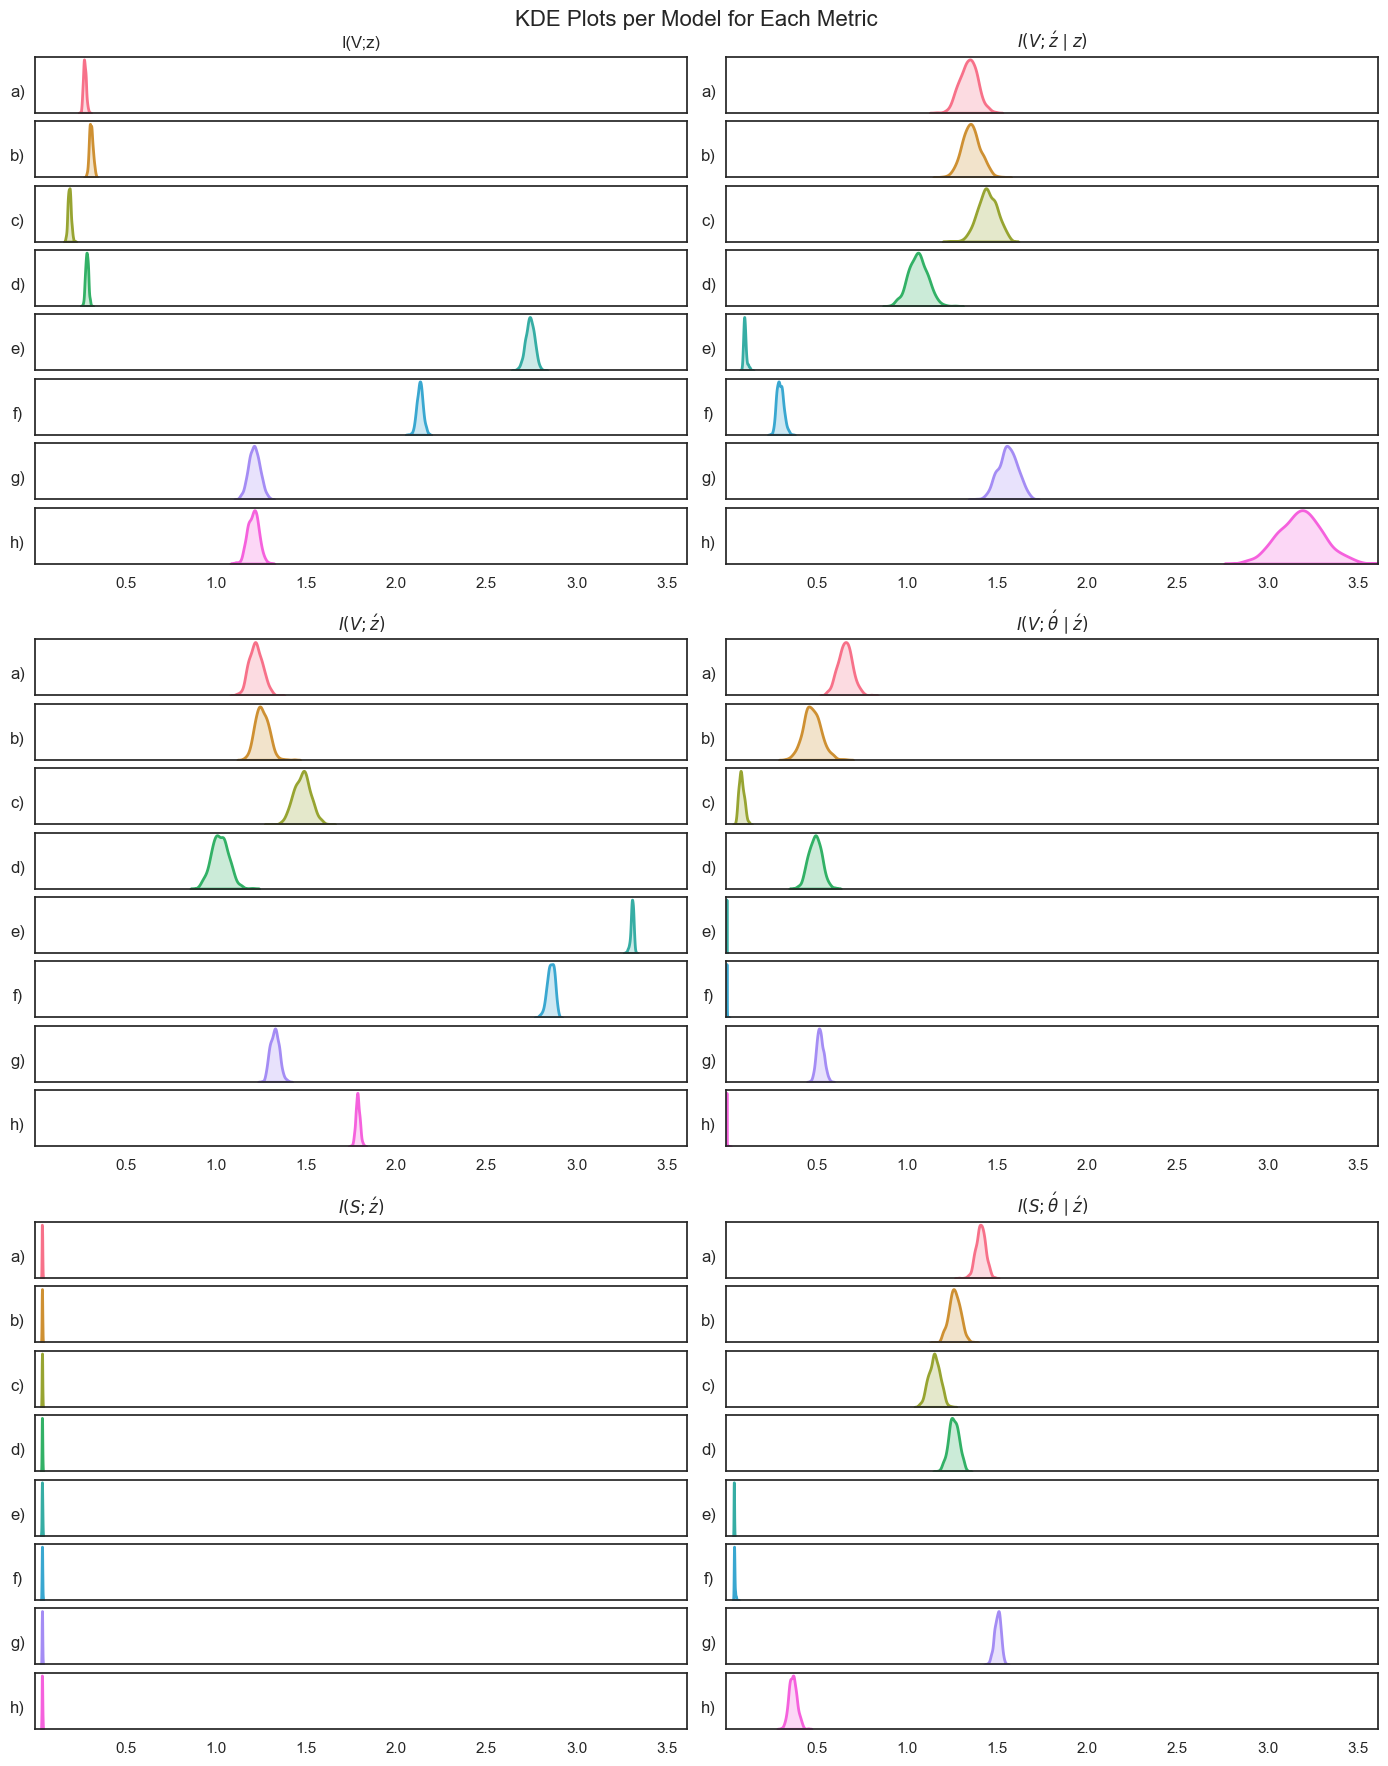

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

alphabet = ['a)','b)','c)','d)','e)','f)','g)','h)']

# Set the aesthetic style of the plots
sns.set(style="white", rc={"axes.facecolor": "white", "grid.color": "white"})

# 'Metrics'와 'Model'의 고유한 값들을 가져옵니다.
metrics_categories = MItables['Metrics'].unique()
model_categories = MItables['Model'].unique()

# 모델별로 다른 색상과 문양을 지정합니다.
palette = sns.color_palette("husl", len(model_categories))  # 색상

# 전체 그림 크기를 설정합니다.
plt.figure(figsize=(14, 18))

# 전체 그리드 스펙을 정의합니다.
gs = GridSpec(3, 2)  # 3x2의 메인 그리드

# x축의 범위를 결정합니다 (데이터에 따라 조정해야 할 수도 있습니다).
x_min = MItables['Values'].min()
x_max = MItables['Values'].max()

# 각 'Metrics'에 대해 subplot 내에 subsubplot을 생성합니다.
for i, metric in enumerate(metrics_categories[:6]):
    # 현재 'Metrics' 값에 해당하는 데이터를 필터링합니다.
    subset = MItables[MItables['Metrics'] == metric]

    # 메인 그리드에서 위치를 지정합니다.
    ax_main = plt.subplot(gs[i // 2, i % 2])
    ax_main.set_title(metric)  # 각 메인 subplot에 제목을 추가합니다.
    ax_main.axis('off')  # 메인 subplot의 축을 숨깁니다.

    # 내부 그리드 스펙을 정의합니다. (모델 수에 따른 그리드)
    gs_sub = GridSpecFromSubplotSpec(len(model_categories), 1, subplot_spec=gs[i // 2, i % 2])

    # 각 'Model'에 대해 내부 subplot에 KDE 플롯을 생성합니다.
    for j, (model, style) in enumerate(zip(model_categories, styles)):
        ax = plt.subplot(gs_sub[j])
        sns.kdeplot(data=subset[subset['Model'] == model], x='Values', ax=ax, color=palette[j], fill=True, linewidth = 2)
        ax.set_xlim(x_min, x_max)  # 모든 subplot에 대해 x축 범위를 통일합니다.
        #ax.set_ylabel(alphabet[j], rotation=0)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  # y축 레이블과 눈금 제거
        ax.grid(False)  # 보조선 제거

        # 마지막 모델만 x축 레이블을 표시합니다.
        if j != len(model_categories) - 1:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

        # y축 레이블을 텍스트 상자로 표시합니다.
        y_max = ax.get_ylim()[1]
        ax.text(-0.1, y_max - 0.5 * y_max, alphabet[j], horizontalalignment='center', verticalalignment='top', fontsize=12)

# 전체 그림에 대한 제목을 추가합니다.
plt.suptitle('KDE Plots per Model for Each Metric', fontsize=16)


# 서브플롯 사이의 간격을 조정합니다.
plt.tight_layout()

# 플롯을 표시합니다.
plt.show()

In [255]:
subset.head()

,Model,Metrics,Values
3000,FACFC_ART_30_800,$I(S;\acute{\theta} \mid \acute{z})$,1.399680
3001,FACFC_ART_30_800,$I(S;\acute{\theta} \mid \acute{z})$,1.415049
3002,FACFC_ART_30_800,$I(S;\acute{\theta} \mid \acute{z})$,1.394497
3003,FACFC_ART_30_800,$I(S;\acute{\theta} \mid \acute{z})$,1.397957
3004,FACFC_ART_30_800,$I(S;\acute{\theta} \mid \acute{z})$,1.411330


#### Selecting post Samp_Zj for generating plausible signals

In [8]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 1.
PostSamp = NewEval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 17797


In [ ]:
NewEval

#### Post EvalKld_TrueGen

1/1 [==============================] - 6s 6s/step
KldPSD_GenTrue:  0.04408587873149387
KldPSD_TrueGen:  0.041194145419431644
MeanKld_GTTG:  0.04264001207546275


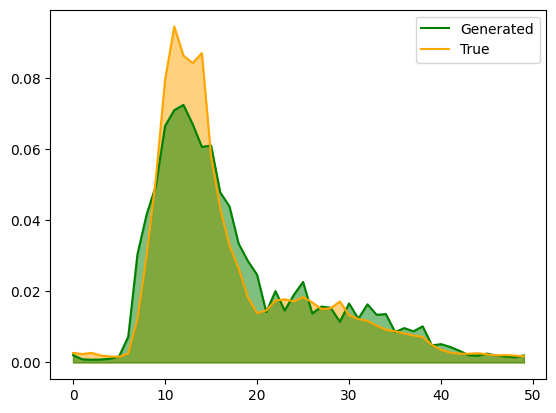

In [9]:
NewEval.GenModel = GenModel
NewEval.KLD_TrueGen(AnalSig=AnalData[:]) 

### Qualitative evaluation

#### Exploring candidates using FreqIDs

In [10]:
TrackerCandZ = NewEval.TrackerCand
BestZsMetrics = NewEval.BestZsMetrics
NewEval.CandFreqIDs
LatDim = 30

#### Visualization of signals given Z values

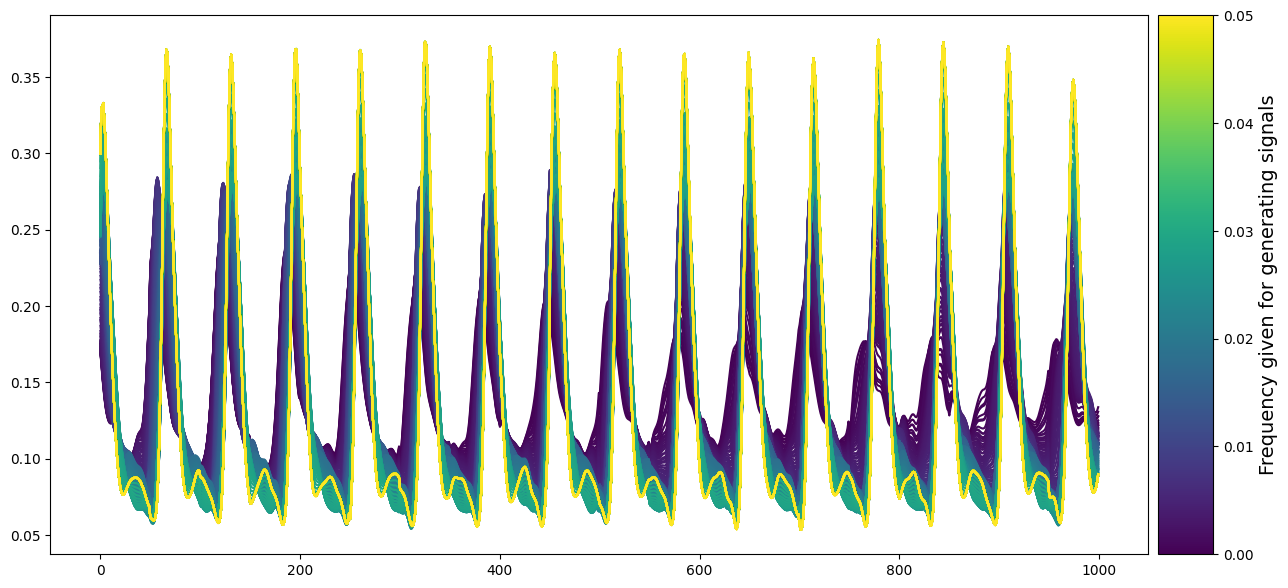

In [16]:
FreqID = 15
ZFixSubID = 1
SelZ =  NewEval.PostSamp[FreqID][ZFixSubID]['TrackZs']

assert ZFixSubID < len(NewEval.PostSamp[FreqID]), 'ZFixSubID must be smaller than ' + str(len(NewEval.PostSamp[FreqID]))

RecPred, HH,HL,LH, LL = VisReconGivenZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

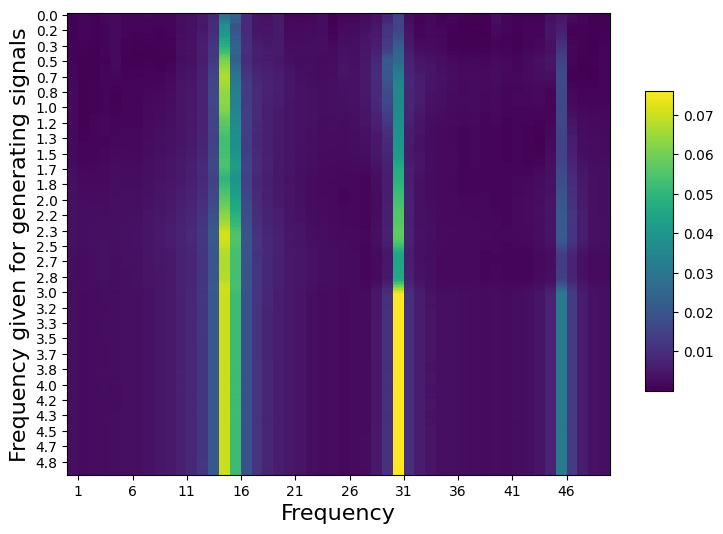

In [17]:
HeatMapFreqZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, N_Gen=300)

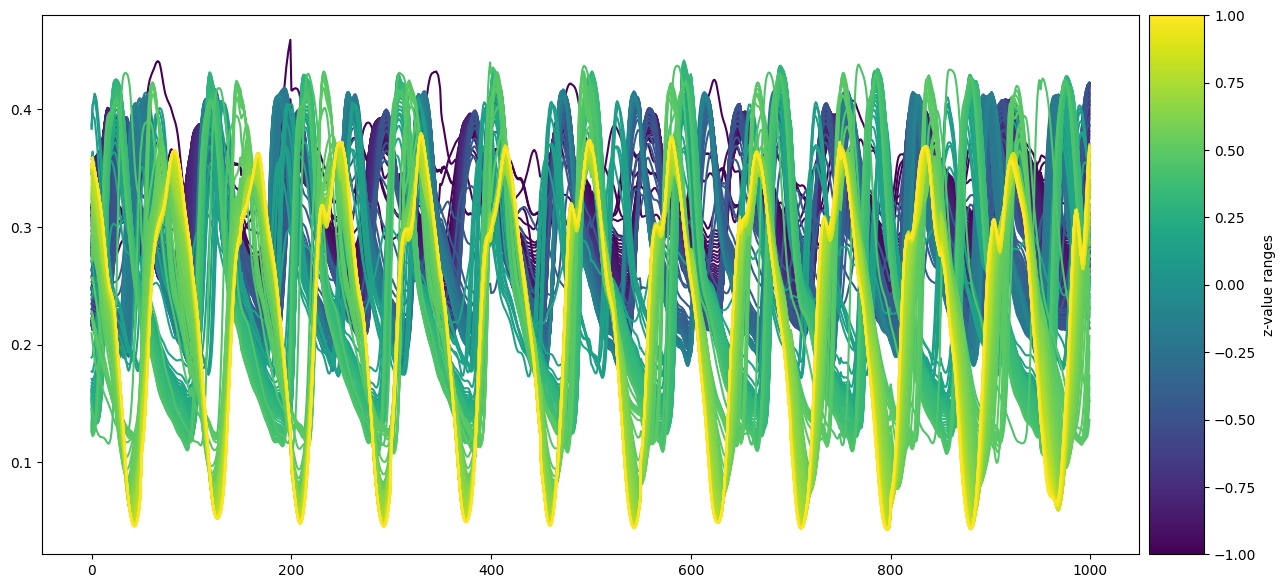

In [20]:
FcCommFix = {0: 0.05, 1: 0.05}
FcEachFix  = {0: 0.05, 1: 0.05, 2: 0.05, 3: 0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFC_ZA (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=300, MinZval = -1., MaxZval = 1., CutLower=-0.1, CutUpper = 0.1)

(100, 1000)


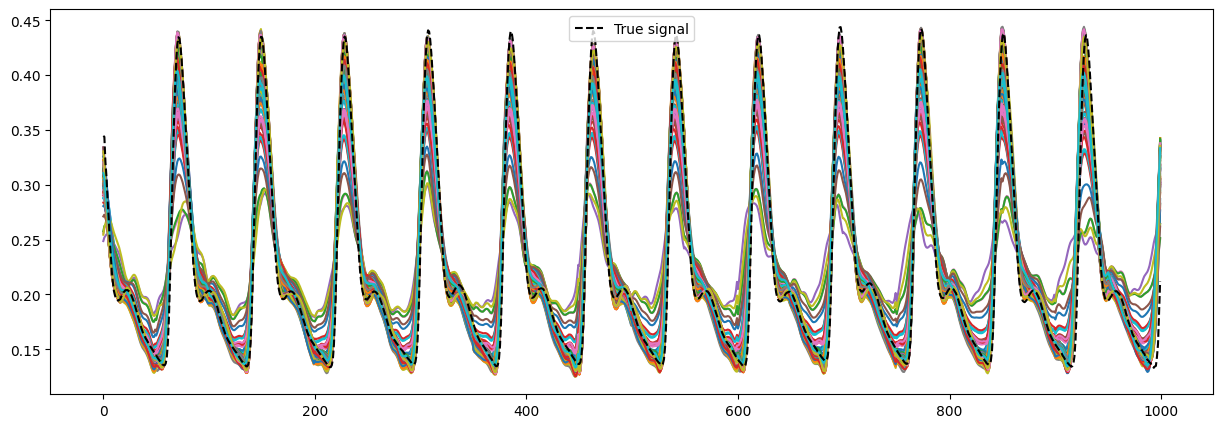

In [19]:
idx = 9871

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtractZ_FC (AnalData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)